In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmcrameri.cm as cm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from aidino.detector import Detector
from aidino.sample import Crystal
from aidino.exodus import load_exodus
from aidino.diffraction import BraggCoherentDiffraction
from aidino.beam import GaussianBeam
from aidino.plot_utils import format_axis
from aidino.xpcs import calculate_two_time_correlation, create_annulus_mask, draw_annulus_mask

In [2]:
dtype = torch.float32
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(dtype)

In [93]:
wavelength = 1.55e-10

detector = Detector(
    num_pixels_i = 128,
    num_pixels_j = 128,
    pixel_size = 75e-6,
    distance = 0.1,
    wavelength = wavelength,
    dtype = dtype,
    device = device
)
resolution = detector.calculate_resolution()
print(f'Detector resolution (ΔX): {resolution:.2g} m')

crystal_size = (60,60,56)

crystal_u = Crystal(
    'cifs/HfO_U1.cif',
    crystal_size = crystal_size,
    wavelength = wavelength,
    include_anomalous = True,
    dtype = dtype,
    device = device
)

crystal_d = Crystal(
    'cifs/HfO_D1.cif',
    crystal_size = crystal_size,
    wavelength = wavelength,
    include_anomalous = True,
    dtype = dtype,
    device = device
)

lengths = crystal_u.lattice_vectors.norm(dim=1)

Detector resolution (ΔX): 1.6e-09 m
Crystal size: 31.4 nm x 30.1 nm x 28.2 nm
Crystal size: 31.4 nm x 30.1 nm x 28.2 nm


In [94]:
crystal_u.visualize_structure()

Display size reduced to (16, 16, 15) to stay within 50,000 atom display limit.
Visualizing crystal of size (16, 16, 15) (46080 atoms)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

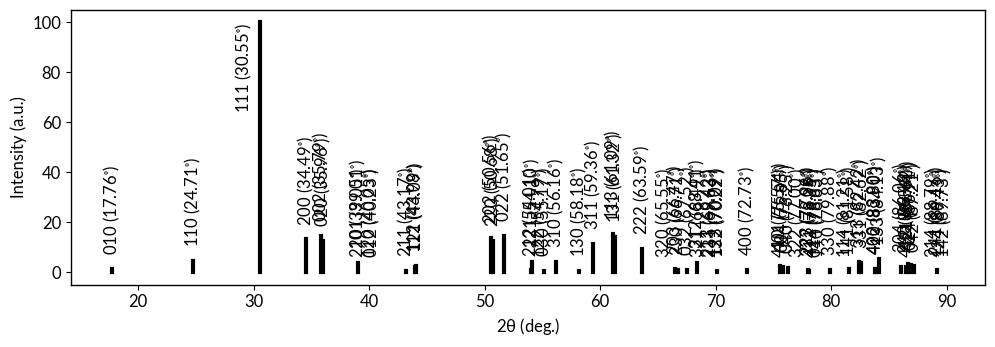

In [95]:
fig = crystal_u.get_xrd_pattern()

In [96]:
crystal_u.list_reflections()

  h   k   l     2θ (degrees)
-----------------------------------
  0   1   0        17.758408
  1   1   0        24.714259
  1   1   1        30.550152
  2   0   0        34.491276
  0   0   2        35.794334
  0   2   0        35.962238
  2   0   1        39.013939
  2   1   0        39.053001
  1   2   0        40.052306
  0   1   2        40.228691
  2   1   1        43.168582
  1   1   2        43.984655
  1   2   1        44.090824
  2   0   2        50.555233
  2   2   0        50.682542
  0   2   2        51.645453
  2   1   2        54.007090
  2   2   1        54.098253
  1   2   2        54.789716
  0   3   0        55.168881
  3   1   0        56.163215
  1   3   0        58.182687
  3   1   1        59.362183
  1   1   3        61.090476
  1   3   1        61.315055
  2   2   2        63.593404
  3   2   0        65.551059
  2   0   3        66.469564
  2   3   0        66.710829
  0   3   2        67.524946
  3   1   2        68.410715
  3   2   1        68.490063
  2   1

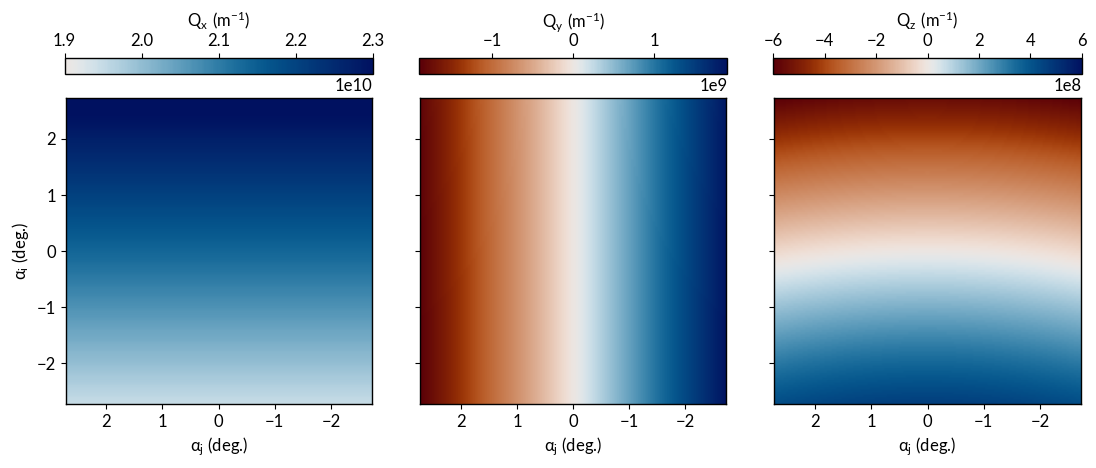

In [97]:
crystal_u.align_miller_plane_to_axis((1,1,1), target_axis='x')
crystal_d.align_miller_plane_to_axis((1,1,1), target_axis='x')

theta_B = torch.deg2rad(torch.tensor(30.55 / 2., dtype=dtype, device=device))
k_i = torch.tensor([torch.sin(-theta_B), 0.0, torch.cos(-theta_B)], dtype=dtype, device=device)
k_f = torch.tensor([torch.sin(theta_B), 0.0, torch.cos(theta_B)], dtype=dtype, device=device)

q_vectors = detector.calculate_q_vectors(k_i, k_f)
fig = detector.plot_q_vectors(q_vectors)

In [98]:
# Require that supercell approximation remains below experiment resolution, i.e. d_i * a_i < ΔX
print('ΔX:', ','.join('{:d}'.format(int(resolution / lengths[i].item())) for i in range(len(lengths))), 'cells')
print('ΔX^3:', '{:d}'.format(np.prod([int(resolution / lengths[i].item()) for i in range(len(lengths))])), 'cells')
print('Oversampling ratio:', detector.calculate_oversampling_ratio(crystal_u.crystal_volume).item())

ΔX: 3,3,3 cells
ΔX^3: 27 cells
Oversampling ratio: 3.4576239585876465


In [99]:
supercell_size = (2,2,2)
q_batch_size = 8

In [10]:
# Load exodus trajectory file
mesh = load_exodus("trajectories/HfO.e")

In [100]:
# Resample fields to crystal grid
field = mesh.resample_to_crystal_grid(
    crystal_u,
    supercell_size = supercell_size,
    coord_scale = 1e-9,
    device = device,
    dtype = dtype
)

Crystal size (60, 60, 56) is 11.1 % smaller than the simulation box. Aligning top corner of crystal with top corner of simulation box. To override, pass an explicit anchor in exodus coordinates (1e-09 m units).


In [101]:
field

CrystalGrid(
  supercell grid         : 30 x 30 x 28
  time steps             : 737
  continuum_displacement : yes
  polarization           : yes
  lattice_strain         : yes
)

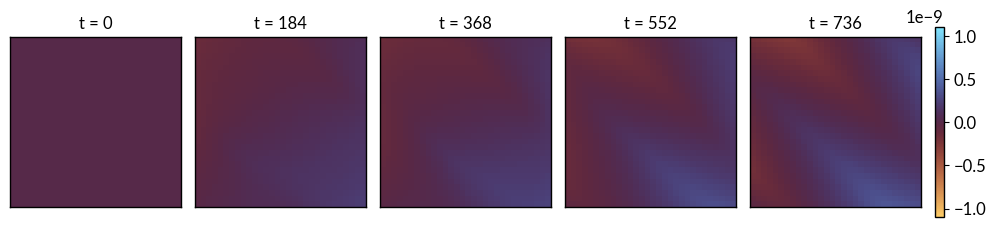

In [102]:
dim = 1
cmap = cm.managua
vmax = field.continuum_displacement[...,dim].abs().amax()
norm = plt.Normalize(vmin=-vmax, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

fig, ax = plt.subplots(1,6, figsize=(10,2.5), gridspec_kw={'width_ratios':[1] * 5 + [0.05]})
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, timestep in enumerate(np.linspace(0, field.n_time_steps - 1, len(ax) - 1, dtype=int)):
    ax[i].imshow(field.continuum_displacement[timestep,:,:,field.continuum_displacement.shape[-2] // 2,dim].cpu(),
                 origin='lower', cmap=cmap, norm=norm)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    format_axis(ax[i], title=f't = {timestep}')

plt.colorbar(sm, cax=ax[-1])
format_axis(ax[-1])

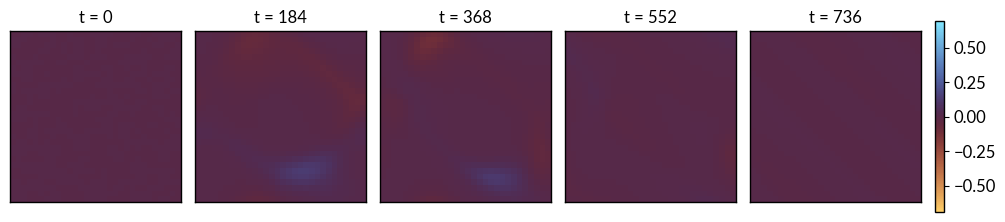

In [103]:
dim = 2
cmap = cm.managua
vmax = field.polarization[...,dim].abs().amax()
norm = plt.Normalize(vmin=-vmax, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

fig, ax = plt.subplots(1,6, figsize=(10,2.5), gridspec_kw={'width_ratios':[1] * 5 + [0.05]})
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, timestep in enumerate(np.linspace(0, field.n_time_steps - 1, len(ax) - 1, dtype=int)):
    ax[i].imshow(field.polarization[timestep,:,:,field.polarization.shape[-2] // 2,dim].cpu(),
                 origin='lower', cmap=cmap, norm=norm)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    format_axis(ax[i], title=f't = {timestep}')

plt.colorbar(sm, cax=ax[-1])
format_axis(ax[-1])

In [104]:
beam = GaussianBeam(
    wavelength = wavelength,
    fwhm = 20e-9,
    device = device
)

beam.create_profile(
    crystal = crystal_u,
    supercell_size = supercell_size,
    k_i = k_i
)

Auto beam entry: crystal +a face, 
Beam_center: (59.0, 30.0, 28.0)


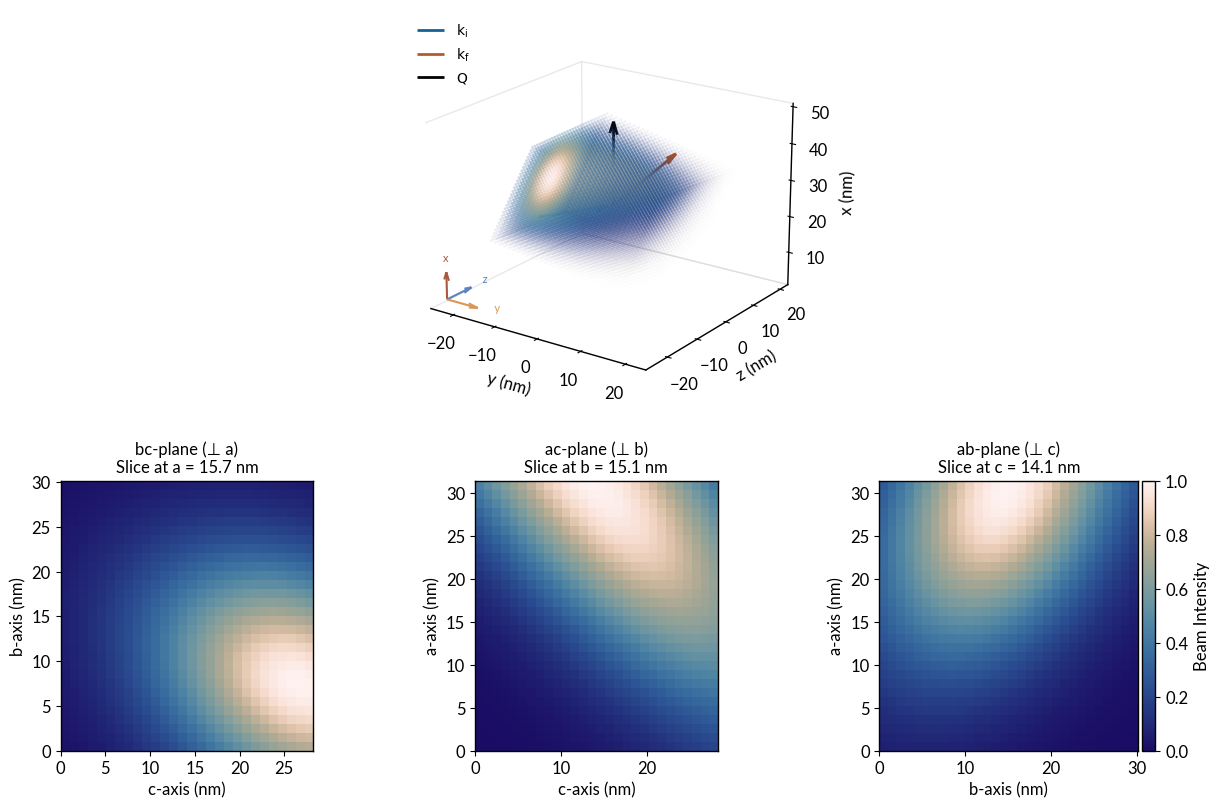

In [105]:
fig = beam.plot_profile(
    crystal = crystal_u,
    supercell_size = supercell_size,
    k_i = k_i,
    k_f = k_f,
    alpha_scale=0.8
)

In [106]:
simulator_u = BraggCoherentDiffraction(
    crystal = crystal_u,
    dtype = dtype,
    device = device
)

simulator_d = BraggCoherentDiffraction(
    crystal = crystal_d,
    dtype = dtype,
    device = device
)

In [107]:
# Create masks for positive and negative polar phases
polar_z_mask_u = F.softplus(field.polarization[...,2])
polar_z_mask_d = F.softplus(-field.polarization[...,2])

Execution time 1.9804890155792236


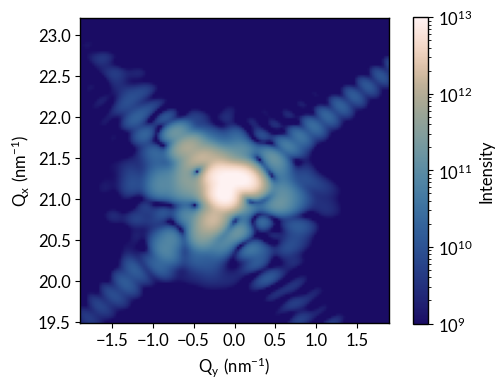

In [108]:
# Calculate intensity for a single timestep
timestep = 200
t_start = time.time()
amplitude = simulator_u.calculate_supercell_scattering(q_vectors, supercell_size, q_batch_size=q_batch_size,
                                                       continuum_displacement=field.continuum_displacement[[timestep]],
                                                       mask=beam.profile * polar_z_mask_u[[timestep]]) + \
            simulator_d.calculate_supercell_scattering(q_vectors, supercell_size, q_batch_size=q_batch_size,
                                                       continuum_displacement=field.continuum_displacement[[timestep]],
                                                       mask=beam.profile * polar_z_mask_d[[timestep]])
intensity = (amplitude.abs() ** 2)
print('Execution time', time.time() - t_start, 's')
fig = detector.plot_intensity(intensity[-1], q_vectors)

Execution time 69.45547080039978


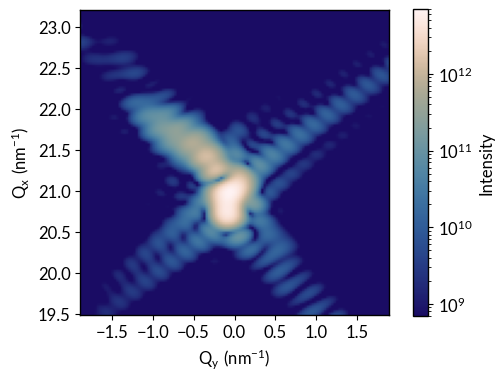

In [109]:
# Calculate intensity for all timesteps
t_start = time.time()
amplitude = simulator_u.calculate_supercell_scattering(q_vectors, supercell_size, continuum_displacement=field.continuum_displacement,
                                                       mask=beam.profile * polar_z_mask_u, q_batch_size=q_batch_size) + \
            simulator_d.calculate_supercell_scattering(q_vectors, supercell_size, continuum_displacement=field.continuum_displacement,
                                                       mask=beam.profile * polar_z_mask_d, q_batch_size=q_batch_size)
intensity = (amplitude.abs() ** 2)
print('Execution time', time.time() - t_start, 's')
fig = detector.plot_intensity(intensity[-1], q_vectors)

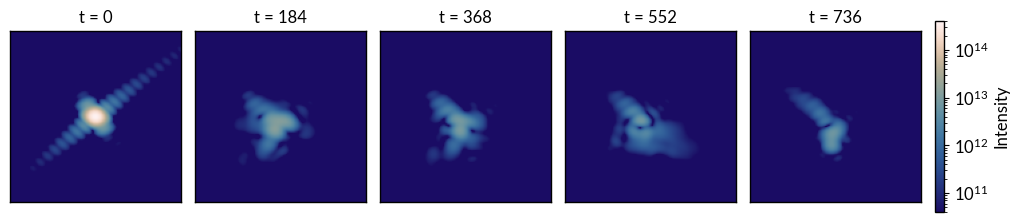

In [110]:
cmap = cm.lapaz
vmax = Detector.round_in_base(intensity[0].max().item(), digits=1)
vmin = vmax / 1e4 if vmax >= 1e4 else 1
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax, clip=1)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

fig, ax = plt.subplots(1,6, figsize=(10,2.5), gridspec_kw={'width_ratios':[1] * 5 + [0.05]})
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, timestep in enumerate(np.linspace(0, len(intensity)-1, len(ax) - 1, dtype=int)):
    ax[i].imshow(intensity[timestep].cpu(), origin='lower', cmap=cmap, norm=norm)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    format_axis(ax[i], title=f't = {timestep}')

plt.colorbar(sm, cax=ax[-1])
format_axis(ax[-1], ylabel='Intensity')

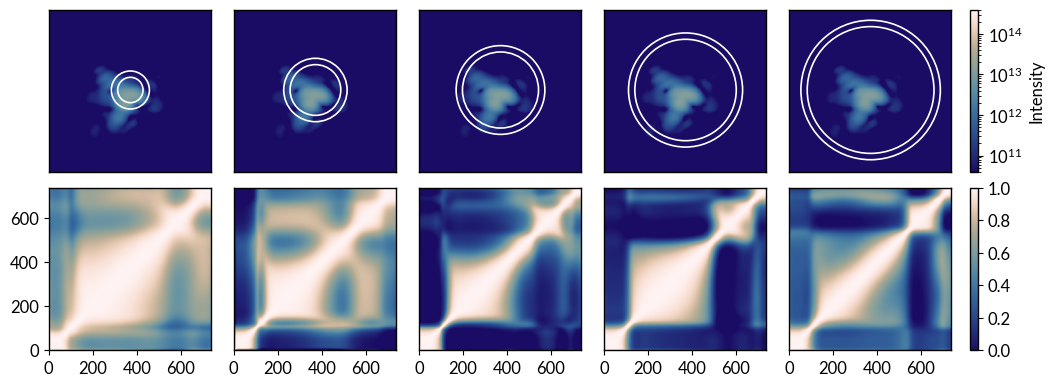

In [111]:
timestep = 200 # Timestep used to visualize annulus masks
cmap = cm.lapaz
vmax = Detector.round_in_base(intensity[0].max().item(), digits=1)
vmin = vmax / 1e4 if vmax >= 1e4 else 1
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax, clip=1)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

norm_c2 = plt.Normalize(vmin=0., vmax=1.)
sm_c2 = mpl.cm.ScalarMappable(cmap=cmap, norm=norm_c2)

fig, ax = plt.subplots(2,6, figsize=(10,4), gridspec_kw={'width_ratios':[1] * 5 + [0.05]})
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

radii = intensity.shape[-1] // 2 // 6 * np.arange(1,6)
width = 5
for i in range(ax.shape[1] - 1):
    roi = create_annulus_mask(*intensity.shape[1:], radii[i], width)
    
    ax[0,i].imshow(intensity[timestep].cpu(), origin='lower', cmap=cmap, norm=norm)
    draw_annulus_mask(
        ax[0,i],
        r_inner=radii[i],
        width=width,
        center=(intensity.shape[1] // 2,intensity.shape[2] // 2),
        lw=1.2,
        color="white",
    )
    
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    
    C2 = calculate_two_time_correlation(intensity[:,roi].flatten(start_dim=1))
    ax[1,i].imshow(C2.cpu(), origin='lower', interpolation='none', cmap=cmap, norm=norm_c2)
    format_axis(ax[1,i], xbins=5, ybins=5)
    if i > 0:
        ax[1,i].set_yticks([])

plt.colorbar(sm, cax=ax[0,-1])
format_axis(ax[0,-1], ylabel='Intensity')

plt.colorbar(sm_c2, cax=ax[1,-1])
format_axis(ax[1,-1])